In [6]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os

from skimage.io import imread, imsave

from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import fbeta_score, precision_score
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy import ndimage

import cv2

%matplotlib inline

In [2]:
source_dir = os.path.join('train-jpg', 'train-jpg')

In [3]:
x_train = []
y_train = []

train_data = pd.read_csv('train_v2.csv/train_v2.csv')

label_enum = 0
label_map = {}
labels = {}
for tags in train_data['tags']:
    classes = tags.split(" ")
    for label in classes:
        if label not in label_map:
            label_map[label] = label_enum
            labels[label_enum] = label
            label_enum = label_enum + 1
    if label_enum == 17:
        break

for image, tags in train_data.values:
    image_path = source_dir+"/"+image+".jpg"
    img = cv2.imread(image_path)
    img = cv2.resize(img, (139, 139))
    one_hot_labels = np.zeros(len(label_map))
    for label in tags.split(' '):
        one_hot_labels[label_map[label]] = 1
    x_train.append(img/255.0)
    y_train.append(one_hot_labels)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32)

print(x_train.shape)
print(y_train.shape)

(40479, 139, 139, 3)
(40479, 17)


In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size =0.2)
x_test, x_val, y_test, y_val = train_test_split(x_val, y_val, test_size =0.5)

In [7]:
x_train_temp = x_train.copy()
y_train_temp = y_train.copy()
x_train_aug = []
y_train_aug = []
for i in range(17):
    if(np.sum(y_train_temp[:,i],axis=0)>y_train_temp.size/2):
        l = np.where(y_train_temp[:,i] == 0)[0]
        for j in range(1000):
            ind = np.random.choice(l)
            rnd = np.random.choice([1,2,3,4])
            if rnd == 1:
                img = cv2.flip(x_train[ind], 0)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
            elif rnd == 2:
                img = cv2.flip(x_train[ind], 1)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
            elif rnd == 3:
                img = ndimage.rotate(x_train[ind], 180)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
            else:
                img = ndimage.rotate(x_train[ind], 90)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
    else:
        l = np.where(y_train_temp[:,i] == 1)[0]
        for j in range(1000):
            ind = np.random.choice(l)
            rnd = np.random.choice([1,2,3,4])
            if rnd == 1:
                img = cv2.flip(x_train[ind], 0)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
            elif rnd == 2:
                img = cv2.flip(x_train[ind], 1)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
            elif rnd == 3:
                img = ndimage.rotate(x_train[ind], 180)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
            else:
                img = ndimage.rotate(x_train[ind], 90)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
y_train_aug = np.array(y_train_aug, np.uint8)
x_train_aug = np.array(x_train_aug, np.float32)
x_train = np.concatenate((x_train, x_train_aug))
y_train = np.concatenate((y_train, y_train_aug))

In [8]:
pretrained_model = applications.InceptionV3(include_top=False, weights='imagenet', input_shape = (139, 139, 3))
pretrained_model.trainable = False

In [9]:
input_layer = pretrained_model.input
model_output = pretrained_model.output
pooling_layer = GlobalAveragePooling2D()(model_output)
dense_layer = Dense(2048, activation='relu')(pooling_layer)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(17, activation='sigmoid')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)

In [10]:
optimizer = Adam()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128,verbose=2, epochs=10, shuffle=True)

Epoch 1/10
386/386 - 123s - loss: 0.1928 - accuracy: 0.8013 - val_loss: 0.1351 - val_accuracy: 0.8342 - 123s/epoch - 317ms/step
Epoch 2/10
386/386 - 117s - loss: 0.1591 - accuracy: 0.7967 - val_loss: 0.1298 - val_accuracy: 0.8194 - 117s/epoch - 304ms/step
Epoch 3/10
386/386 - 117s - loss: 0.1466 - accuracy: 0.7892 - val_loss: 0.1300 - val_accuracy: 0.8029 - 117s/epoch - 304ms/step
Epoch 4/10
386/386 - 117s - loss: 0.1372 - accuracy: 0.7778 - val_loss: 0.1280 - val_accuracy: 0.7861 - 117s/epoch - 304ms/step
Epoch 5/10
386/386 - 117s - loss: 0.1285 - accuracy: 0.7667 - val_loss: 0.1303 - val_accuracy: 0.8026 - 117s/epoch - 303ms/step
Epoch 6/10
386/386 - 117s - loss: 0.1205 - accuracy: 0.7658 - val_loss: 0.1318 - val_accuracy: 0.7624 - 117s/epoch - 304ms/step
Epoch 7/10
386/386 - 117s - loss: 0.1134 - accuracy: 0.7628 - val_loss: 0.1317 - val_accuracy: 0.7750 - 117s/epoch - 304ms/step
Epoch 8/10
386/386 - 117s - loss: 0.1062 - accuracy: 0.7529 - val_loss: 0.1331 - val_accuracy: 0.7947 - 

In [11]:
model.save_weights("model_aug_pre_final.h5")

In [12]:
for layer in pretrained_model.layers[:176]:
   layer.trainable = False
for layer in pretrained_model.layers[176:]:
   layer.trainable = True

input_layer = pretrained_model.input
model_output = pretrained_model.output
pooling_layer = GlobalAveragePooling2D()(model_output)
dense_layer = Dense(2048, activation='relu')(pooling_layer)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(17, activation='sigmoid')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.load_weights("model_aug_pre_final.h5")

adam = Adam()
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128,verbose=2, epochs=10, shuffle=True)

Epoch 1/10
386/386 - 268s - loss: 0.1618 - accuracy: 0.7653 - val_loss: 0.1139 - val_accuracy: 0.7959 - 268s/epoch - 694ms/step
Epoch 2/10
386/386 - 263s - loss: 0.1192 - accuracy: 0.7448 - val_loss: 0.1308 - val_accuracy: 0.7794 - 263s/epoch - 682ms/step
Epoch 3/10
386/386 - 263s - loss: 0.1032 - accuracy: 0.7236 - val_loss: 0.1500 - val_accuracy: 0.7964 - 263s/epoch - 681ms/step
Epoch 4/10
386/386 - 263s - loss: 0.0919 - accuracy: 0.6959 - val_loss: 0.1180 - val_accuracy: 0.7006 - 263s/epoch - 682ms/step
Epoch 5/10
386/386 - 263s - loss: 0.0818 - accuracy: 0.6909 - val_loss: 0.1303 - val_accuracy: 0.7875 - 263s/epoch - 682ms/step
Epoch 6/10
386/386 - 263s - loss: 0.0708 - accuracy: 0.6700 - val_loss: 0.1350 - val_accuracy: 0.7238 - 263s/epoch - 680ms/step
Epoch 7/10
386/386 - 269s - loss: 0.0622 - accuracy: 0.6531 - val_loss: 0.1343 - val_accuracy: 0.7806 - 269s/epoch - 696ms/step
Epoch 8/10
386/386 - 264s - loss: 0.0540 - accuracy: 0.6544 - val_loss: 0.1542 - val_accuracy: 0.7624 - 

In [13]:
model.save_weights('model_aug_final_2.h5')

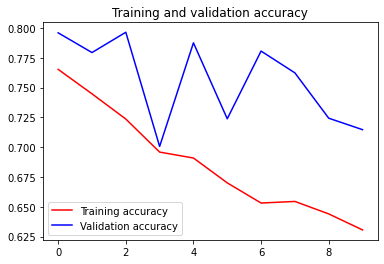

<Figure size 432x288 with 0 Axes>

In [14]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))

plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

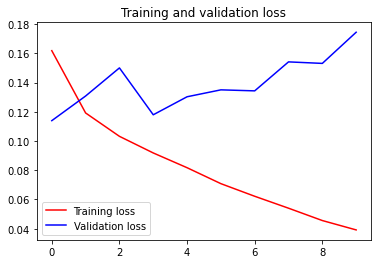

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [16]:
y_pred = model.predict(x_test, batch_size = 128, verbose=2)

32/32 - 10s - 10s/epoch - 298ms/step


In [17]:
f2_score = fbeta_score(y_test, np.array(y_pred)>0.2, beta=2, average='samples')
print("F2 score:",f2_score)

F2 score: 0.8936970676832587


In [18]:
y_pred = np.array(y_pred)>0.2
total = np.sum(y_test,axis = 0)
tp = np.sum(y_test*y_pred,axis=0)
tn = np.sum((1-y_test)*(1-y_pred),axis=0)
fp = np.sum((1-y_test)*y_pred,axis=0)
fn = np.sum(y_test*(1-y_pred),axis=0)

d = {'Total':total,'TP':tp,'TN':tn,'FP':fp,'FN':fn}
pd.DataFrame(d, index=label_map)


,Total,TP,TN,FP,FN
haze,273,207,3549,226,66
primary,3761,3673,233,54,88
agriculture,1202,1036,2520,326,166
clear,2835,2719,1094,119,116
water,744,603,2961,343,141
habitation,356,249,3528,164,107
road,798,637,3096,154,161
cultivation,464,264,3294,290,200
slash_burn,24,1,4000,24,23
cloudy,218,211,3699,131,7


In [19]:
sum = np.add(tp, fp)
precision = np.divide(tp, sum)
recall = np.divide(tp, np.add(tp, fn))
accuracy = np.divide(np.add(tp, tn), np.add(fp, np.add(fn, np.add(tp, tn))))
f1 = 2*(np.divide(np.multiply(precision, recall), np.add(precision, recall)))
f2 = (np.divide(5*np.multiply(precision, recall), np.add(4*precision, recall)))
evalution_metrics = {'Accuracy':accuracy,'Precision':precision,'Recall':recall,'f1':f1, 'f2': f2}
pd.DataFrame(evalution_metrics, index=label_map)

,Accuracy,Precision,Recall,f1,f2
haze,0.927866,0.478060,0.758242,0.586402,0.678689
primary,0.964921,0.985511,0.976602,0.981036,0.978371
agriculture,0.878458,0.760646,0.861897,0.808112,0.839546
clear,0.941947,0.958069,0.959083,0.958576,0.958880
water,0.880435,0.637421,0.810484,0.713609,0.768740
habitation,0.933053,0.602906,0.699438,0.647594,0.677735
road,0.922184,0.805310,0.798246,0.801762,0.799649
cultivation,0.878953,0.476534,0.568966,0.518664,0.547718
slash_burn,0.988389,0.040000,0.041667,0.040816,0.041322
cloudy,0.965909,0.616959,0.967890,0.753571,0.869028


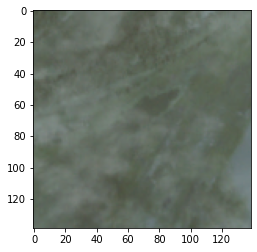

1/1 - 0s - 22ms/epoch - 22ms/step
[ True  True  True False False False False False False False  True False
 False False False False False]
True label
primary agriculture partly_cloudy 
Predicted
haze primary agriculture partly_cloudy 


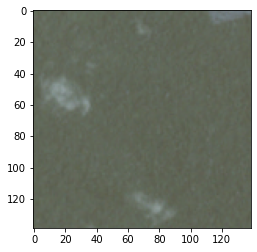

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary agriculture partly_cloudy 
Predicted
primary partly_cloudy 


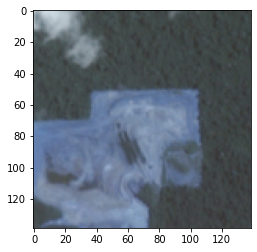

1/1 - 0s - 22ms/epoch - 22ms/step
[False  True False False False  True False False False False  True  True
  True False False False False]
True label
primary partly_cloudy conventional_mine 
Predicted
primary habitation partly_cloudy conventional_mine bare_ground 


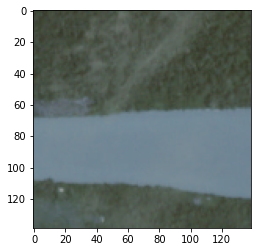

1/1 - 0s - 22ms/epoch - 22ms/step
[False  True False False  True  True False False False False  True False
 False False False False False]
True label
primary water habitation partly_cloudy 
Predicted
primary water habitation partly_cloudy 


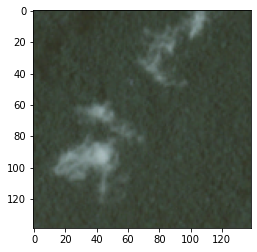

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary partly_cloudy 


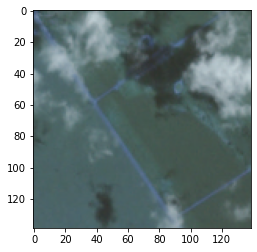

1/1 - 0s - 22ms/epoch - 22ms/step
[False  True  True False  True  True  True False False False  True False
 False False False False False]
True label
primary agriculture road cultivation partly_cloudy 
Predicted
primary agriculture water habitation road partly_cloudy 


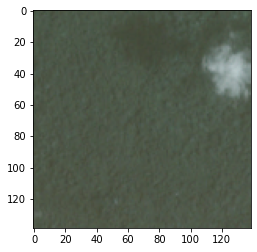

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary partly_cloudy 


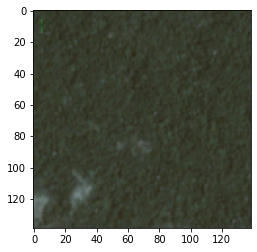

1/1 - 0s - 20ms/epoch - 20ms/step
[False  True False  True False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary clear partly_cloudy 


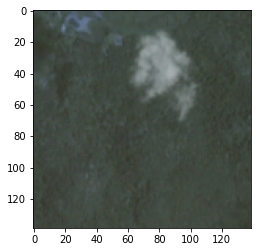

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True False False False False False  True False False  True False
 False False False False False]
True label
primary agriculture road cultivation partly_cloudy 
Predicted
primary cultivation partly_cloudy 


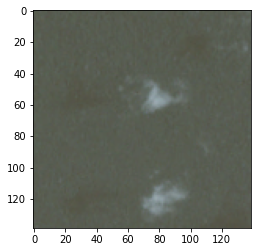

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary partly_cloudy 


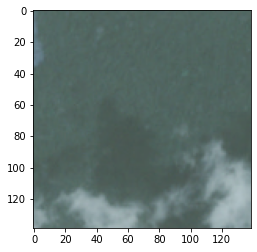

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary agriculture partly_cloudy 
Predicted
primary partly_cloudy 


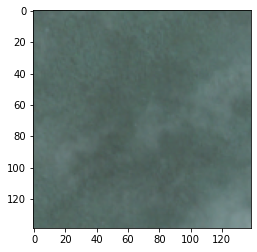

1/1 - 0s - 21ms/epoch - 21ms/step
[ True  True False False False False False False False False False False
 False False False False False]
True label
primary partly_cloudy 
Predicted
haze primary 


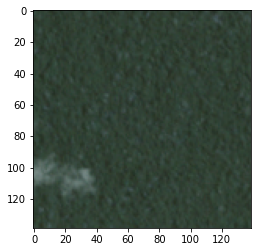

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary partly_cloudy 


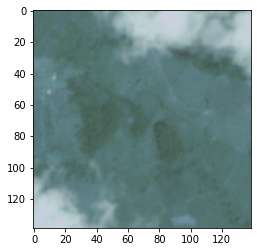

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True  True False False  True  True  True False False  True False
  True False False False False]
True label
primary agriculture partly_cloudy 
Predicted
primary agriculture habitation road cultivation partly_cloudy bare_ground 


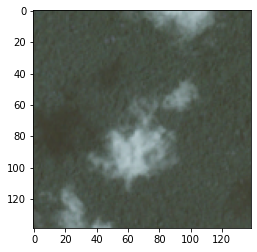

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary partly_cloudy 


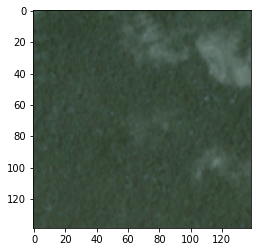

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary partly_cloudy 


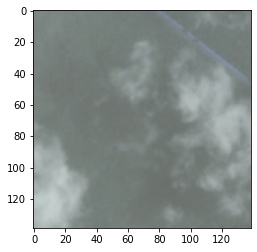

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True False False  True False  True False False False  True False
 False False False False False]
True label
primary water road partly_cloudy 
Predicted
primary water road partly_cloudy 


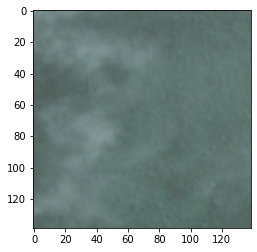

1/1 - 0s - 21ms/epoch - 21ms/step
[ True  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
haze primary partly_cloudy 


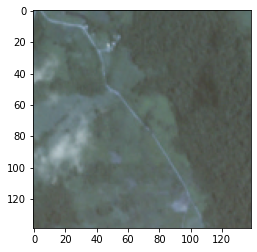

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True  True False  True False  True  True False False  True False
 False False False False False]
True label
primary agriculture habitation road partly_cloudy 
Predicted
primary agriculture water road cultivation partly_cloudy 


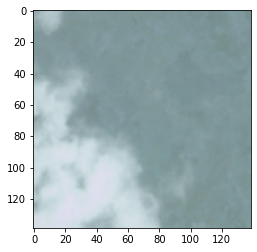

1/1 - 0s - 24ms/epoch - 24ms/step
[False  True  True False False False False False False False  True False
 False False False False False]
True label
primary agriculture partly_cloudy 
Predicted
primary agriculture partly_cloudy 


In [20]:
j = 0
k=0
while(j<20 and k<len(x_test)):
    img = x_test[k]
    tags = ''
    y = y_test[k]
    cloudy = False
    for i in range(len(y)):
        if y[i] == 1:
            tags = tags + labels[i] + ' '
            if labels[i] == 'partly_cloudy':
                cloudy = True
    if cloudy:
        plt.imshow(img)
        plt.show()
        img = np.expand_dims(img, axis = 0)
        y = model.predict(img, batch_size = 1, verbose=2)
        y_pred = np.array(y > 0.2).reshape(-1)
        print(y_pred)
        preds = ""
        for i in range(len(y_pred)):
            if y_pred[i] != 0:
                preds = preds+labels[i]+" "
        print('True label')
        print(tags)
        print('Predicted')
        print(preds)
        j+=1
    k=k+1